### Load VGG19 Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
model = tf.keras.applications.vgg19.VGG19(weights='imagenet')

574726144/574710816 [==============================] - 146s 0us/step


In [4]:
#How does the model look
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Load an Image

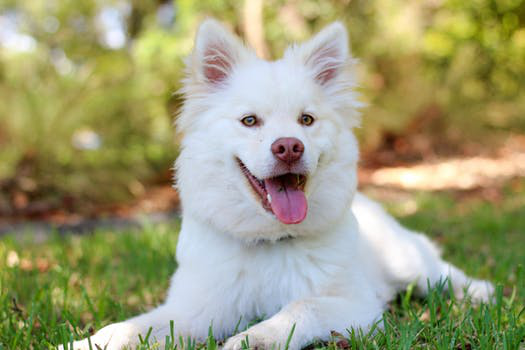

In [5]:
img = tf.keras.preprocessing.image.load_img('dog.jpeg')
img

### Prediction

In [6]:
import numpy as np

In [7]:
#Prepare image prediction
img_array = tf.keras.preprocessing.image.img_to_array(img.resize((224, 224)))

#Normalize the image
img_array[:,:,0] -= 103.939
img_array[:,:,1] -= 116.779
img_array[:,:,2] -= 123.68

#Create a batch
img_array = np.expand_dims(img_array, axis=0)

#Get the prediction
prediction = model.predict(img_array)

#Get the index with highest probability
pred_index = np.argmax(prediction[0])

#Decode prediction
prediction = tf.keras.applications.vgg19.decode_predictions(prediction)

pred_index, prediction

49152/35363 [=========================================] - 0s 1us/step


(258,
 [[('n02111889', 'Samoyed', 0.22122197),
   ('n02099601', 'golden_retriever', 0.18063827),
   ('n02111500', 'Great_Pyrenees', 0.11692172),
   ('n02106030', 'collie', 0.09201663),
   ('n02106166', 'Border_collie', 0.09147957)]])

ImageNet Class IDs
- https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

### Are we sure model is looking at the right place?

Create a Patch to be applied

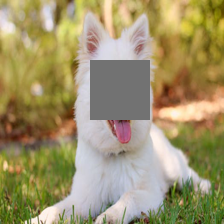

In [8]:
new_img_array = np.copy(img_array)
new_img_array[0][60:120, 90:150] = 0

tf.keras.preprocessing.image.array_to_img(new_img_array[0])

In [55]:
#Get the prediction
prediction = model.predict(new_img_array)

prediction[0][pred_index]

0.040610734

In [44]:
import math

In [80]:
patch_size = 20
stride = 10

output_width = int(math.ceil(224 - patch_size)/stride + 1)
output_height = int(math.ceil(224 - patch_size)/stride + 1)

output_width, output_height

(21, 21)

In [81]:
heatmap = np.zeros((output_height, output_width))

In [82]:
for h in range(output_height):
    
    for w in range(output_width):
        
        #Create a patch
        h_start = h * stride
        w_start = w * stride
        
        #Create original image copy
        img_copy = img.copy()
        
        img_array = tf.keras.preprocessing.image.img_to_array(img_copy.resize((224, 224)))
        #Normalize the image
        img_array[:,:,0] -= 103.939
        img_array[:,:,1] -= 116.779
        img_array[:,:,2] -= 123.68
        
        #Update image with the patch
        img_array[h_start:h_start+patch_size, w_start: w_start+patch_size] = 0
        
        #Create a batch
        img_array = np.expand_dims(img_array, axis=0)

        #Get the prediction
        prediction = model.predict(img_array)[0]
        
        #Probability for right label, store it in the heatmap
        heatmap[h,w] = prediction[pred_index]

In [83]:
import matplotlib.pyplot as plt

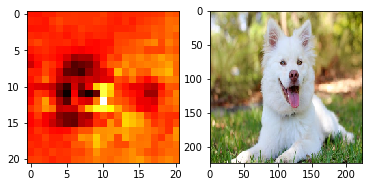

In [84]:
plt.subplot(1,2,1)
plt.imshow(np.transpose(heatmap,(1,0)), cmap='hot', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(img.resize((224,224)))